In [9]:
import dark_soup
import matplotlib.pyplot as plt
import numpy as np
import limpy.lines as ll
import limpy.powerspectra as lp
import limpy.params as p
import limpy.utils as lu
import limpy.plotter as lplt

import scipy
import astropy
from astropy.cosmology.realizations import Planck18

In [2]:
fig_dir = './figures'
halo_file_path = './data/halos_L205_z7.00.npz'
survey_data_path = './data/combined_data.csv'
survey_npz_path = './data/combined_data.npz'

z = 7.0
line_name = 'CII158'
model_name = 'Fonseca16'
sfr_model = 'Silva15'

In [3]:
def plt_ps(x, y, y_label, title, file_name):
    plt.figure(dpi=500)
    plt.loglog(x, y, lw=3)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(r"$k\, [h/\mathrm{Mpc}]$")
    plt.savefig(fig_dir + '/' + file_name)

Fonseca16
[7.60731597e-06 7.60731597e-06 7.60731597e-06 ... 5.97519810e+08
 5.97133818e+08 5.96748076e+08]


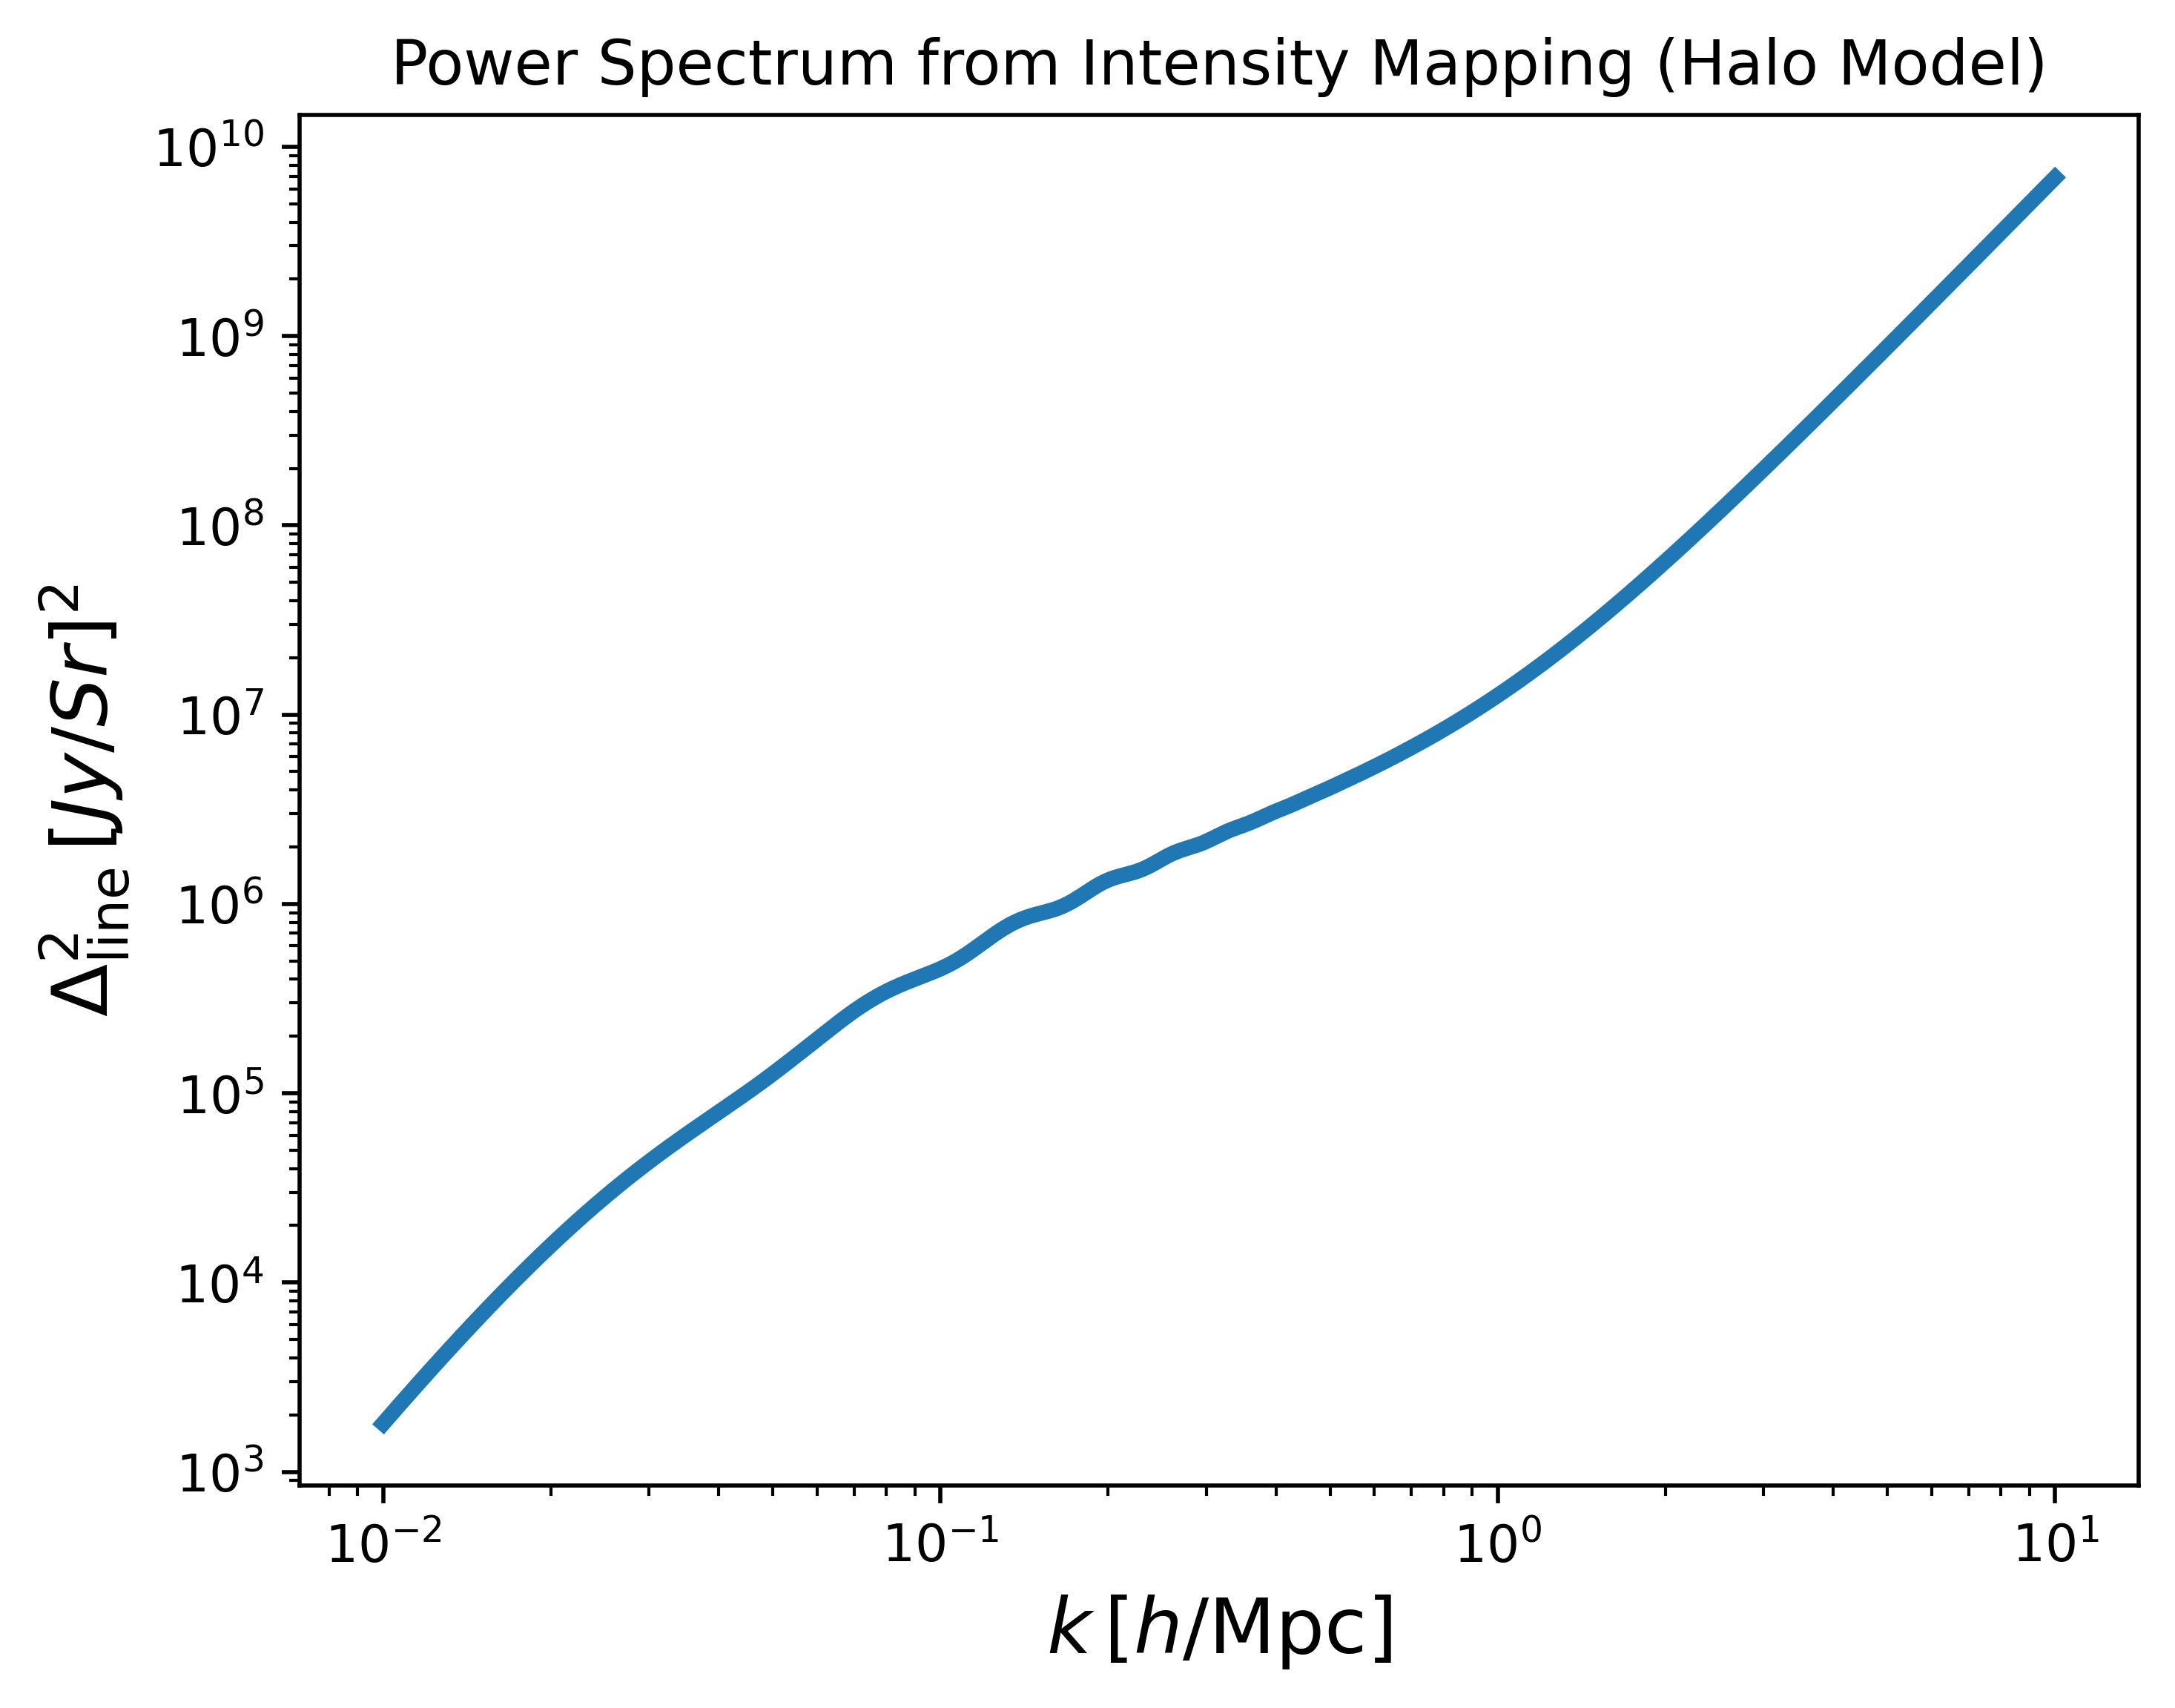

In [4]:
k, pk = dark_soup.get_ps_intensity_mapping(
    z=z,
    line_name=line_name,
    model_name=model_name,
    sfr_model=sfr_model,
)

plt_ps(
    k, lu.dk(k, pk),
    r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$",
    title='Power Spectrum from Intensity Mapping (Halo Model)',
    file_name='ps_intensity_mapping_halo_model.png',
)

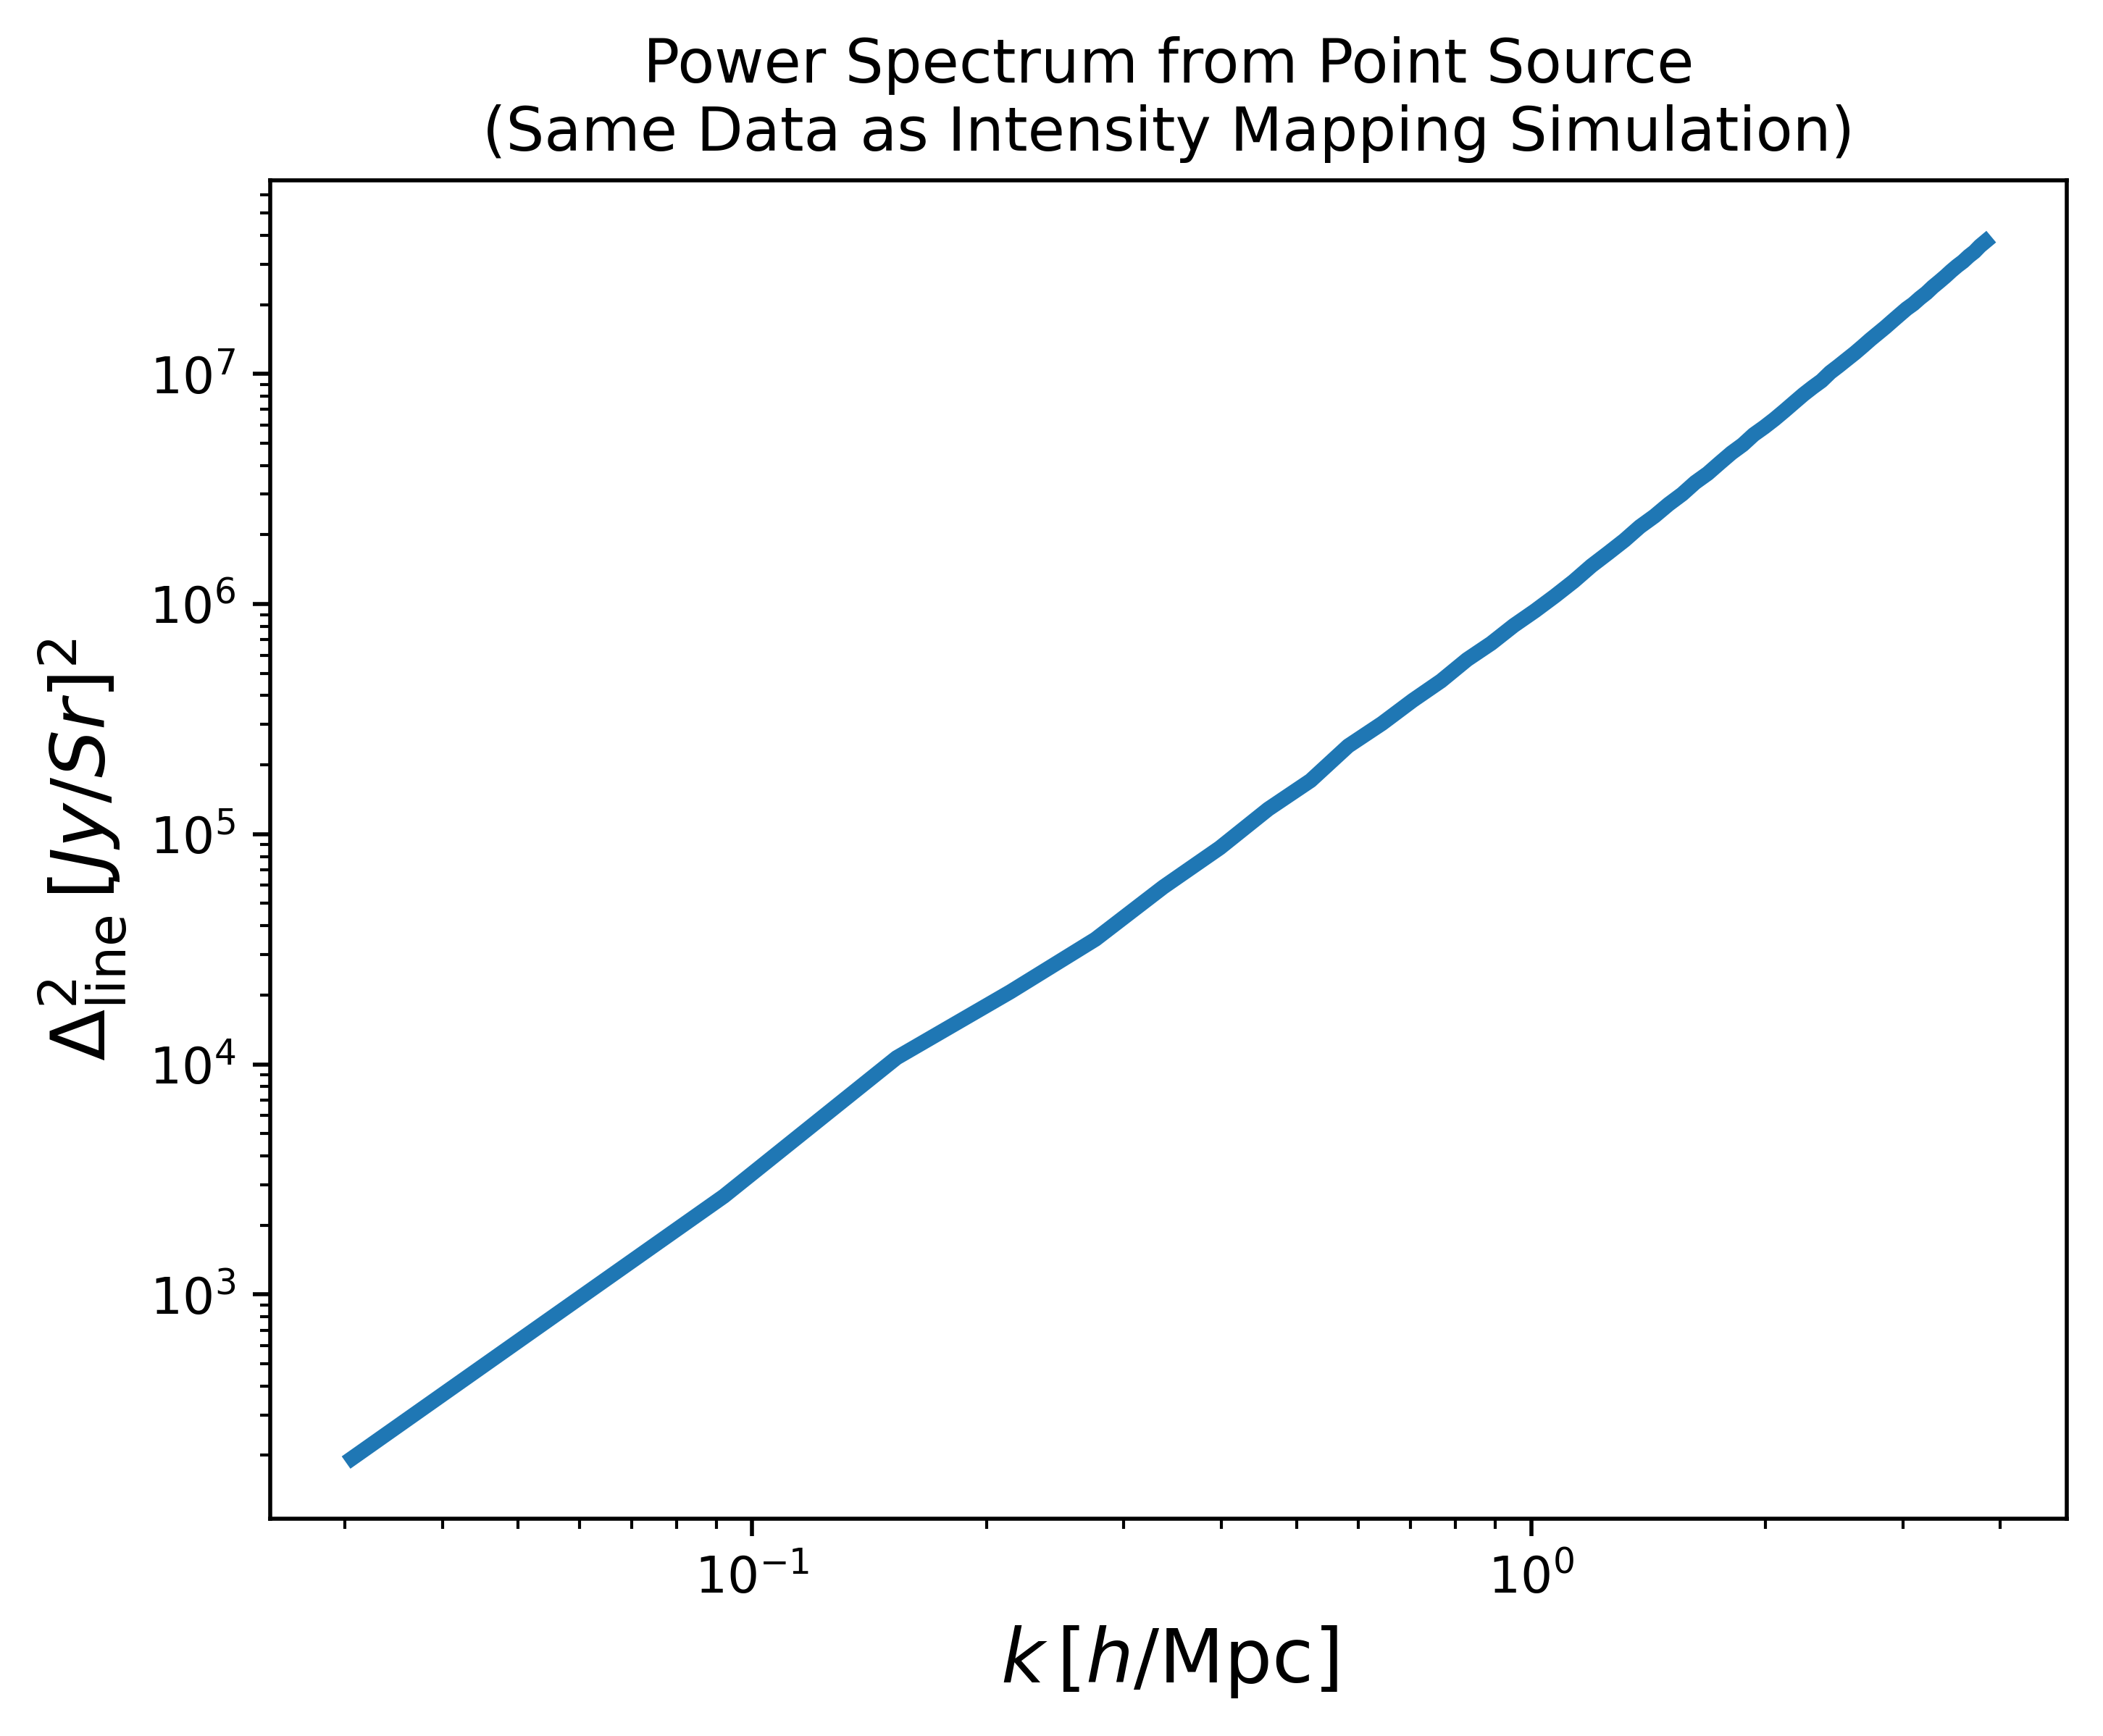

In [5]:
k, pk = dark_soup.get_ps_point_sources(
    z=z,
    halo_file_path=halo_file_path,
    line_name=line_name,
    model_name=model_name,
    sfr_model=sfr_model,
)

plt_ps(
    k, lu.dk(k, pk),
    r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$",
    title='Power Spectrum from Point Sources\n(Same Data as Intensity Mapping Simulation)',
    file_name='ps_point_source_compare.png',
)

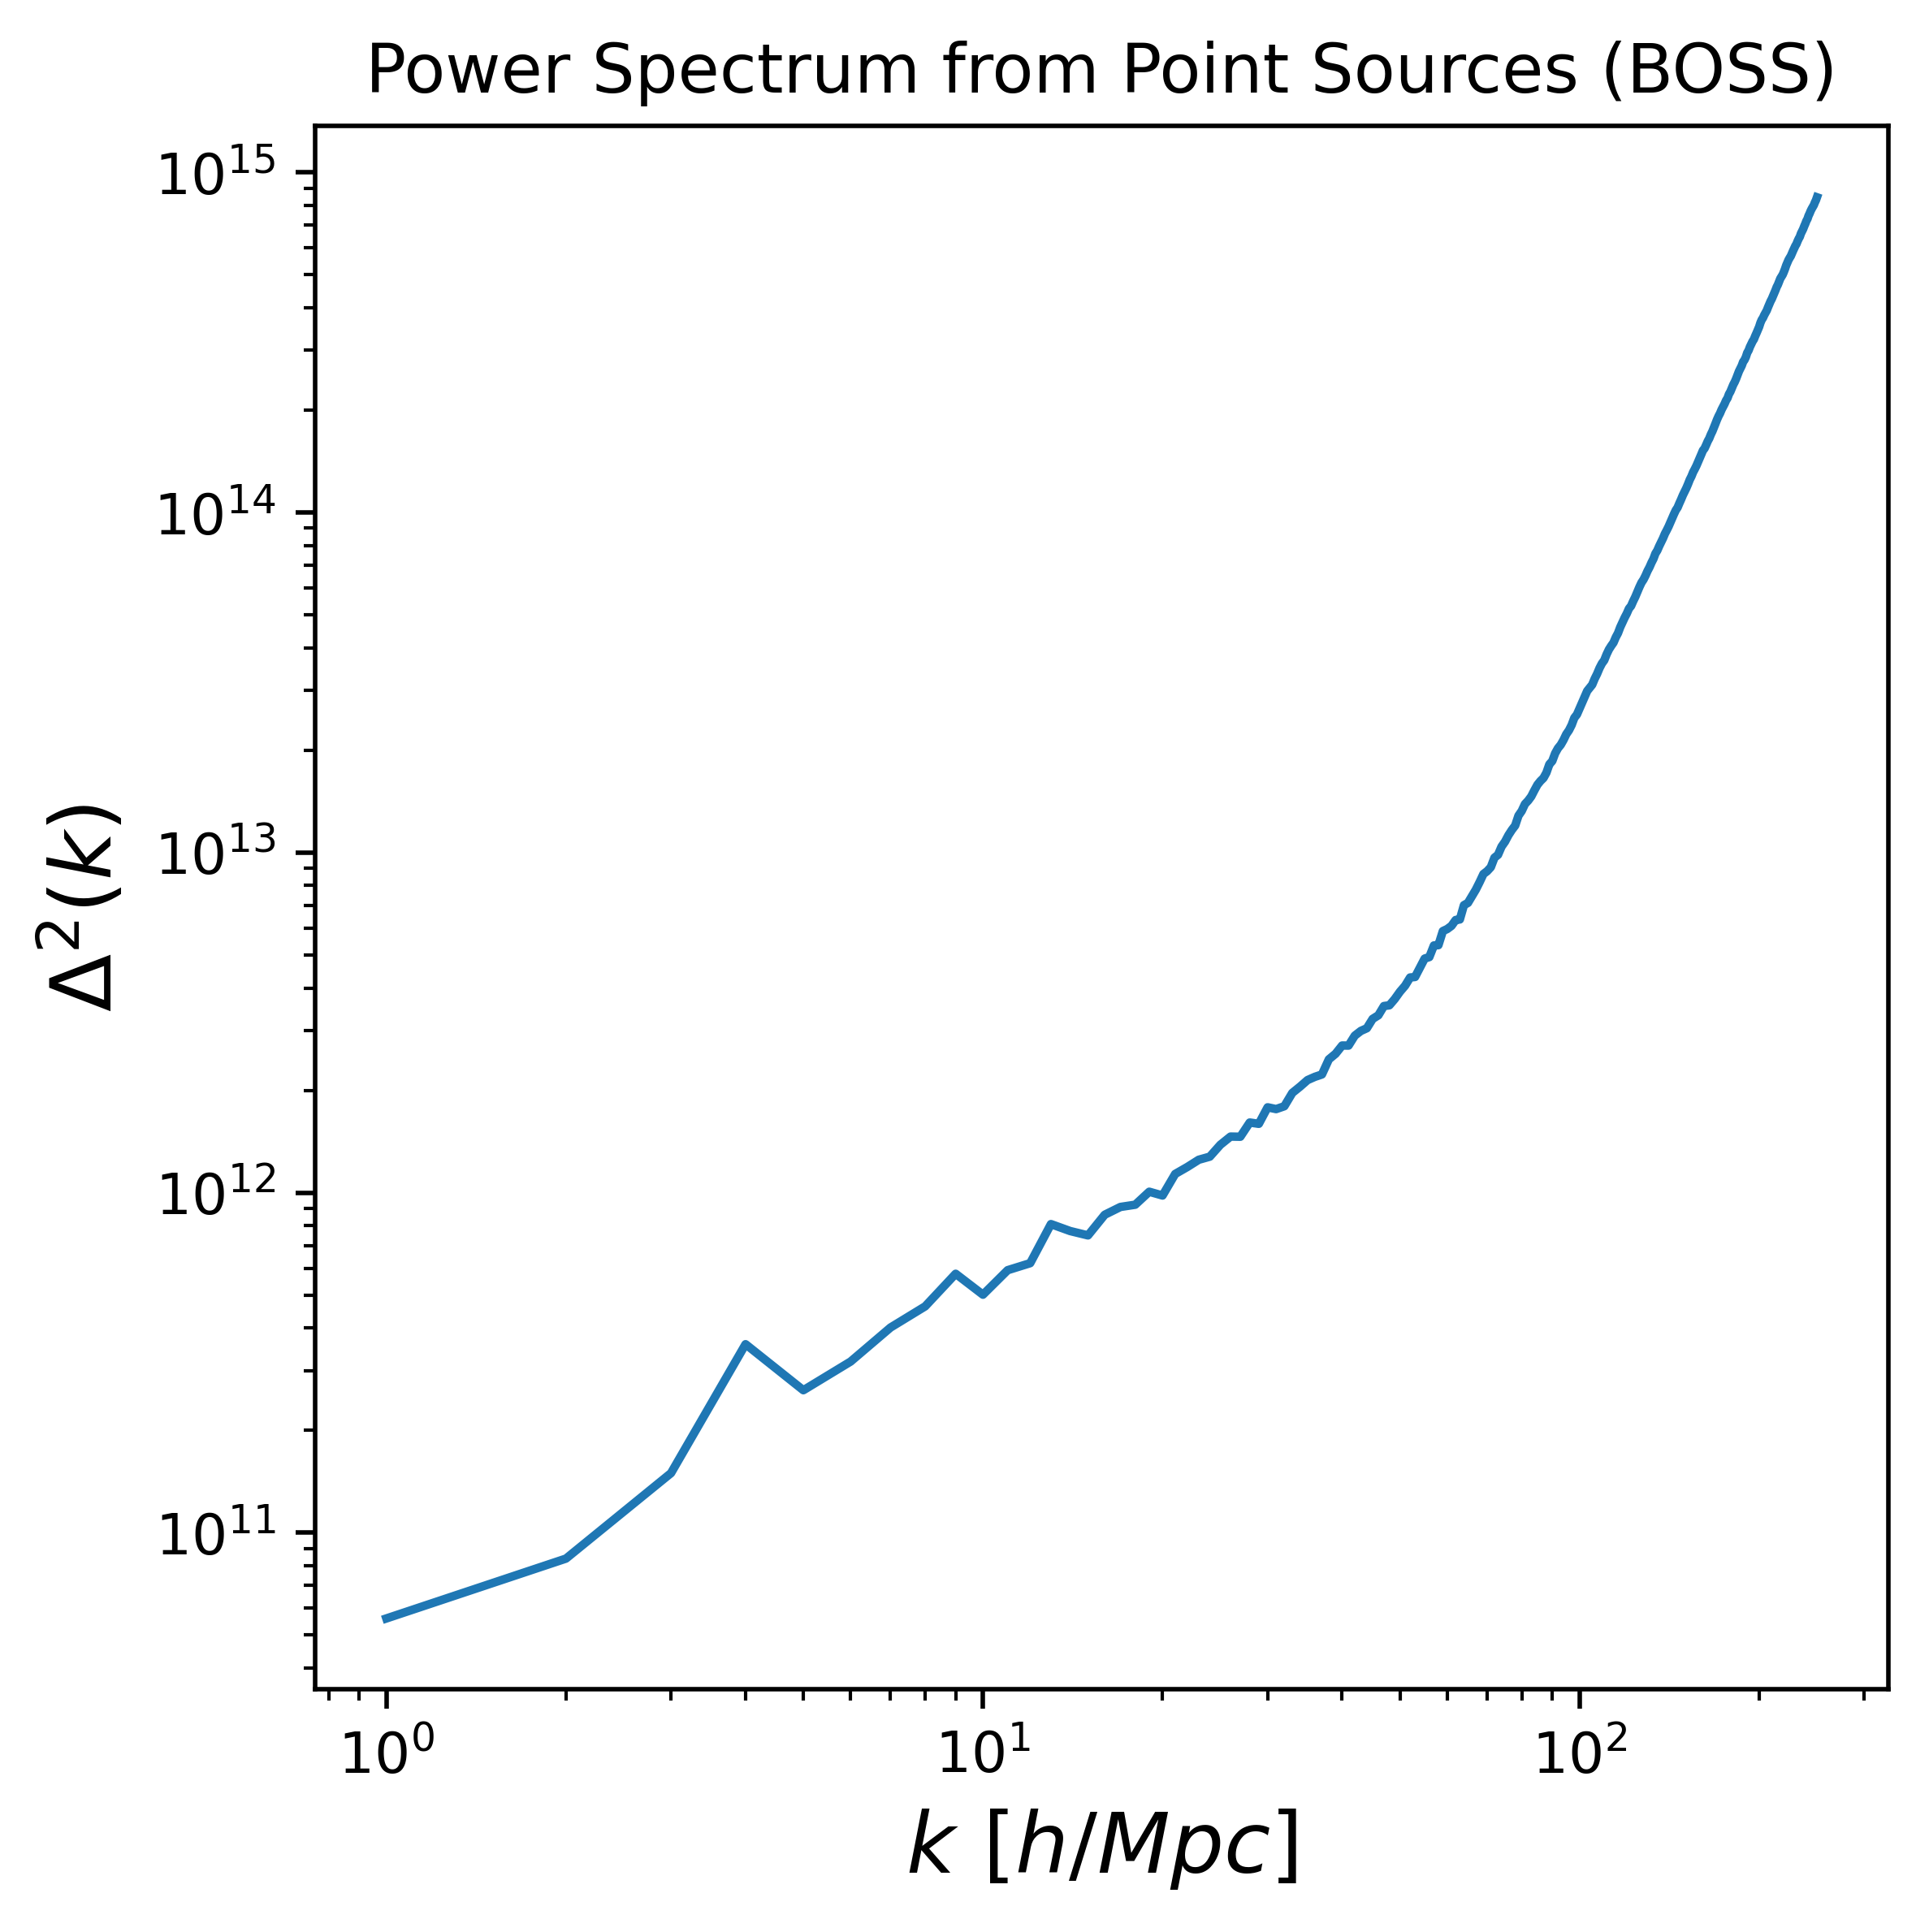

In [26]:
location_data = np.genfromtxt(survey_data_path, skip_header=1, delimiter=',')
location_data = np.transpose(location_data)
ra = location_data[0] #phi = ra
dec = location_data[1] #theta = pi/2-dec
z = location_data[2]
# x = rsin(theta)cos(phi)
# y = rsin(theta)sin(phi)
# z = rcos(theta)
r = Planck18.comoving_distance(z)
x = r*np.sin(np.pi/2-dec)*np.cos(ra)
y = r*np.sin(np.pi/2-dec)*np.sin(ra)
z = r*np.cos(np.pi/2-dec)


#x = process(x)
#y = process(y)
#z = process(z)
# Save as NPZ file
np.savez(survey_npz_path, x=x, y=y, z=z, m=np.ones(len(x)))

data = np.load(survey_npz_path)
x, y, z = data['x'], data['y'], data['z']
ngrid = 500

hist_grid = np.histogramdd((x, y, z), bins=ngrid)[0]

fourier_amplitudes = np.abs(np.fft.fftn(hist_grid)) **2
fourier_amplitudes = fourier_amplitudes.flatten()

kfreq = np.fft.fftfreq(ngrid) * ngrid
kfreq3D = np.meshgrid(kfreq, kfreq, kfreq)
knrm = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)

knrm = knrm.flatten()
kbins = np.arange(0.5, ngrid//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = scipy.stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
delta_squared = Abins * (kvals**3 / (2 * np.pi)**2)

plt.figure(figsize=(5, 5), dpi=500)
plt.loglog(kvals, delta_squared)

#plt.loglog(k, lu.dk(k, pk) * (3.0660139380653E-7)**2)


plt.xlabel(r"$k\ [h/Mpc]$")
plt.ylabel(r"$\Delta^2 (k)$")
plt.title('Power Spectrum from Point Sources (BOSS)')
plt.savefig(fig_dir + '/' + 'ps_boss.png', format="png")